# Data Importing

In [1]:
#Import The required Python libraries.
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger,ProgbarLogger
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2
import time

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Changable_Parameter**

In [5]:
#here image size is 256x256
IMAGE_SIZE = 256
#every time process 32 images (61x31)~1951
batch_size = 20
#how many color have in these pictures
CHANNELS = 3
#80x25~1951
EPOCHS = 50
NUM_CLASSES = 4
input_shape = (batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
patience=5
data_dir ="C:\\Users\\akton\\Documents\\CPASTONE\\New folder2"
split_folder="C:\\Users\\akton\\Documents\\CPASTONE\\splitted"
model_name="densenet201"  

**Directory Creation and split**

In [6]:
import os
import shutil
import random
import math

# Example paths

train_val_dir = os.path.join(split_folder, "train_validation_data")
test_dir = os.path.join(split_folder, "test_data")

def split_data(source_folder, split_folder, train_val_ratio=0.9):
    # Check if split folders already exist
    if os.path.exists(train_val_dir) and os.path.exists(test_dir):
        print("Split folders already exist. Skipping data split.")
        return
    
    # Create split folders if they do not exist
    if not os.path.exists(split_folder):
        os.makedirs(split_folder)
    if not os.path.exists(train_val_dir):
        os.makedirs(train_val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    # Count variables
    train_val_count = 0
    test_count = 0
    
    # Iterate through source_folder (main folder with classes)
    for class_folder in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_folder)
        
        if os.path.isdir(class_path):
            # Create corresponding folders in split_folder
            train_val_class_path = os.path.join(train_val_dir, class_folder)
            test_class_path = os.path.join(test_dir, class_folder)
            
            if not os.path.exists(train_val_class_path):
                os.makedirs(train_val_class_path)
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)
            
            # List all images in the class folder
            images = [img for img in os.listdir(class_path) if img.endswith('.jpg') or img.endswith('.png')]
            random.shuffle(images)
            
            # Calculate split indices
            split_index = int(len(images) * train_val_ratio)
            
            # Split images into train_validation_data and test_data
            train_val_images = images[:split_index]
            test_images = images[split_index:]
            
            # Copy images to respective split folders
            for img in train_val_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(train_val_class_path, img)
                shutil.copy(src, dst)
                train_val_count += 1
                
            for img in test_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(test_class_path, img)
                shutil.copy(src, dst)
                test_count += 1
    
    print("Data split completed successfully.")
    print(f"Number of images in train_validation_data: {train_val_count}")
    print(f"Number of images in test_data: {test_count}")
    print(f"Total number of images: {train_val_count + test_count}")

# Call the function with your paths
split_data(data_dir, split_folder)


Split folders already exist. Skipping data split.


In [7]:
import os
import shutil
import random
import tensorflow as tf
# Define image parameters

# Define data augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.10+.03,  # 10% of the data will be used for validation
)

train_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='training'  # specify that this generator will be used for training data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


validation_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='validation'  # specify that this generator will be used for validation data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical'  # Update for multi-class classification
)


Found 4136 images belonging to 4 classes.
Found 616 images belonging to 4 classes.
Found 528 images belonging to 4 classes.


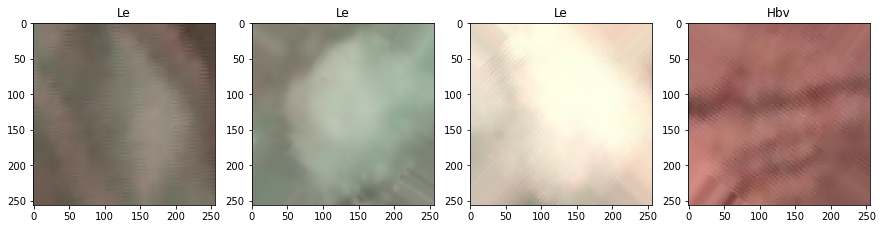

In [8]:
images, labels = next(train_generator)

# Plot four random images from the batch
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # Generate a random index
    random_index = np.random.randint(0, batch_size)
    
    # Plot the image
    axes[i].imshow(images[random_index])
    
    # Get the corresponding label
    label = labels[random_index]
    
    # Set the title as the class name
    class_name = train_generator.class_indices
    axes[i].set_title(list(class_name.keys())[np.argmax(label)])

plt.show()

# Building model

In [9]:
from tensorflow.keras.applications import ResNet50,InceptionV3,NASNetMobile,DenseNet201

model= DenseNet201(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
                 )

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 BatchNormalization False
8 Activation False
9 Conv2D False
10 BatchNormalization False
11 Activation False
12 Conv2D False
13 Concatenate False
14 BatchNormalization False
15 Activation False
16 Conv2D False
17 BatchNormalization False
18 Activation False
19 Conv2D False
20 Concatenate False
21 BatchNormalization False
22 Activation False
23 Conv2D False
24 BatchNormalization False
25 Activation False
26 Conv2D False
27 Concatenate False
28 BatchNormalization False
29 Activation False
30 Conv2D False
31 BatchNormalization False
32 Activation False
33 Conv2D False
34 Concatenate False
35 BatchNormalization False
36 Activation False
37 Conv2D False
38 BatchNormalization False
39 Activation False
40 Conv2D False
41 Concatenate False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 BatchNormalization False
46 Activation False
4

**Fine Tuning**

In [10]:
for layer in model.layers[:367]:
   layer.trainable = False
for layer in model.layers[367:]:
   layer.trainable = True

# print('Last block of the conv_base is now trainable')


for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [11]:

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed on top of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    top_model = Dropout(0.5)(top_model) 
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


In [12]:
from keras.models import Model
FC_Head = lw(model, NUM_CLASSES)
model = Model(inputs = model.input, outputs = FC_Head)


# Training

In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
     if epoch < 5:
         return .002
     else:
        return .0008

lr_scheduler = LearningRateScheduler(scheduler)

In [14]:
if not os.path.exists("Results"):
    os.makedirs("Results")
if not os.path.exists("Model"):
    os.makedirs("Model") 
csv_logger_path = os.path.join("Results", f"{model_name}_results.csv")
model_checkpoint_path = os.path.join("Model", f"{model_name}_Model.hdf5")

**CheckPoints**

In [15]:

csv_logger = CSVLogger(csv_logger_path)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
check = ModelCheckpoint(model_checkpoint_path, verbose=1, save_best_only=True)
progbar_logger = ProgbarLogger()

In [16]:

training_time = time.time()
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(train_generator,
                    epochs=EPOCHS, 
                    batch_size=batch_size,
                    validation_data=validation_generator,
                    verbose = 1,
                    callbacks = [early_stopping,lr_scheduler,check,csv_logger],
                    initial_epoch=0)

Epoch 1/50
207/207 [==============================] - 70s 239ms/step - loss: 1.9536 - accuracy: 0.8960 - val_loss: 1.9394 - val_accuracy: 0.8182

Epoch 00001: val_loss improved from inf to 1.93944, saving model to Model\densenet201_Model.hdf5
Epoch 2/50
207/207 [==============================] - 40s 195ms/step - loss: 0.3036 - accuracy: 0.9504 - val_loss: 0.1781 - val_accuracy: 0.9513

Epoch 00002: val_loss improved from 1.93944 to 0.17809, saving model to Model\densenet201_Model.hdf5
Epoch 3/50
207/207 [==============================] - 42s 205ms/step - loss: 0.2045 - accuracy: 0.9722 - val_loss: 0.2295 - val_accuracy: 0.9659

Epoch 00003: val_loss did not improve from 0.17809
Epoch 4/50
207/207 [==============================] - 39s 189ms/step - loss: 0.4118 - accuracy: 0.9555 - val_loss: 0.1943 - val_accuracy: 0.9724

Epoch 00004: val_loss did not improve from 0.17809
Epoch 5/50
207/207 [==============================] - 39s 188ms/step - loss: 0.2073 - accuracy: 0.9686 - val_loss: 0

In [17]:
# Calculate the total training time
total_time = time.time() - training_time
# Convert total time into minutes and seconds
minutes = total_time // 60
seconds = total_time % 60
print(f"Total Training Time: {int(minutes)} minutes and {seconds:.2f} seconds")

Total Training Time: 11 minutes and 35.21 seconds


**saving models**

In [18]:
import pickle

pickle_path_json = os.path.join("Results", f"{model_name}_model_architecture.json")
pickle_model_path = os.path.join("Model", f"{model_name}_model_pickle.pkl")

# Save model architecture to JSON (only needed once)
model_architecture = model.to_json()
with open(pickle_path_json, 'w') as f:
    f.write(model_architecture)

# Save model weights using pickle
with open(pickle_model_path, 'wb') as f:
    pickle.dump(model, f)

RecursionError: maximum recursion depth exceeded

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [20]:
model.save(model_name)


INFO:tensorflow:Assets written to: densenet201\assets


In [21]:
model.save(f'{model_name}.h5')

In [22]:
# model.save(f'{model_name}.h5')

model_name = 'my_model'
try:
    model.save(f'{model_name}.h5')
    print(f"Model saved as {model_name}.h5")
except Exception as e:
    print(f"Error saving model: {e}")

Model saved as my_model.h5


In [39]:
# model = tf.keras.models.load_model(f'{model_name}_.h5')

In [40]:
# history_path = os.path.join("Results", f"{model_name}__training_history.xlsx")
# import pandas as pd
# history_df = pd.DataFrame(history_path.history)
# history_df.to_excel(history_path, index=False)

# Result

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

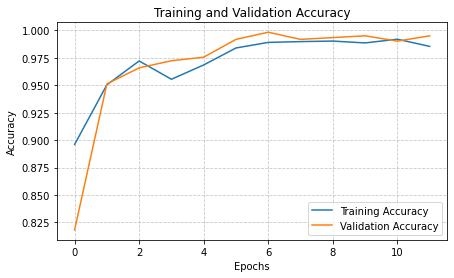

In [24]:

plt.figure(figsize=(7, 4))
plt.plot((epochs ), history.history['accuracy'], label='Training Accuracy')
plt.plot((epochs ), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

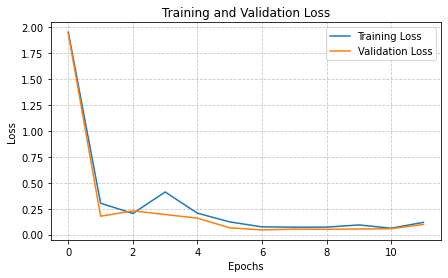

In [25]:
plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
        

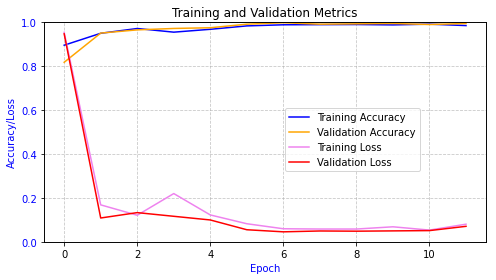

In [26]:
import matplotlib.pyplot as plt

# Assuming the following are defined:
# epochs: list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
# history: training history object containing 'accuracy', 'val_accuracy', 'loss', and 'val_loss' metrics

fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot Training and Validation Accuracy
ax1.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')

# Set y-axis label and limits for accuracy
ax1.set_ylabel('Accuracy/Loss', color='blue')
ax1.set_xlabel('Epoch', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 1])  # Limit y-axis for accuracy between 0 and 1

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(epochs, history.history['loss'], label='Training Loss', color='violet')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')

# Hide y-axis ticks and labels for loss
ax2.set_yticks([])  # Remove y-axis ticks
ax2.set_ylabel('')  # Set empty string to hide the label

# Add grid, legends, title, and x-axis label
ax1.grid(True, linestyle='--', alpha=0.7)

# Combine legends for accuracy and loss in the middle right
handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Adjust legend position to be slightly left of center right
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.85, 0.5))

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')

# Show plot
plt.tight_layout()
plt.show()


In [27]:
score = model.evaluate(test_generator ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

27/27 [==============================] - 6s 208ms/step - loss: 0.0993 - accuracy: 0.9962
Test Loss: 0.09934826195240021
Test accuracy: 99.62121248245239


In [28]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true_all, y_pred_all, target_names=class_labels, zero_division=1,digits=4)



In [29]:
print(report)

              precision    recall  f1-score   support

         Hbv     1.0000    1.0000    1.0000       132
          He     0.9925    1.0000    0.9962       132
        IPCL     0.9925    1.0000    0.9962       132
          Le     1.0000    0.9848    0.9924       132

    accuracy                         0.9962       528
   macro avg     0.9962    0.9962    0.9962       528
weighted avg     0.9962    0.9962    0.9962       528



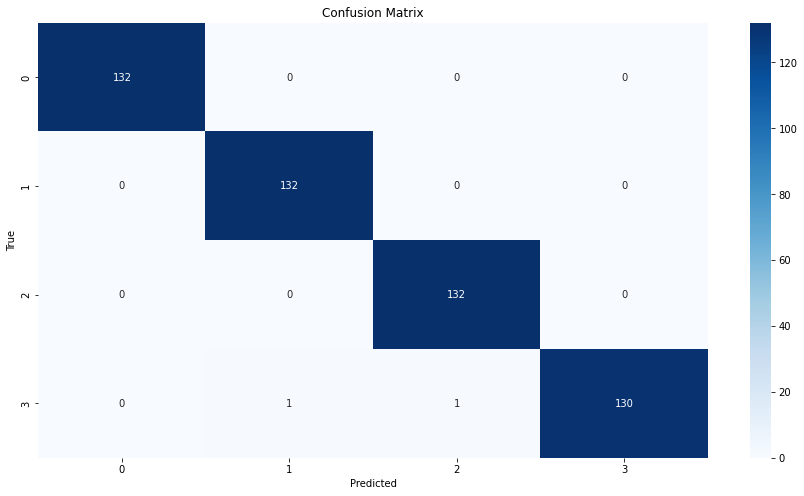

In [30]:
cm = confusion_matrix(y_true_all, y_pred_all)
import seaborn as sns
# Get class labels
class_labels = list(validation_generator.class_indices.keys())
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
# Plot confusion matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

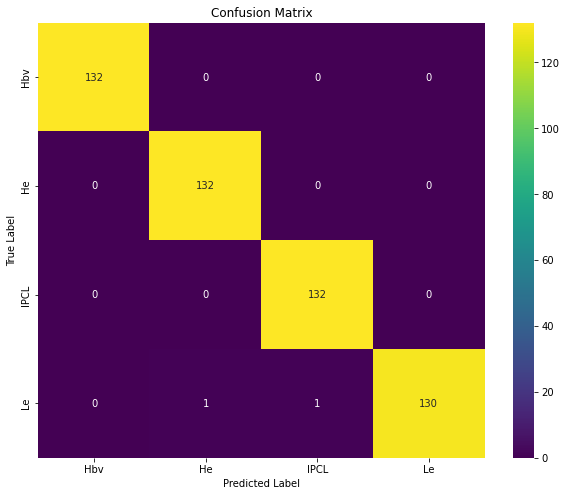

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Plot confusion matrix with a colorful palette
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [32]:
start_time = time.time()
predicted_vals = model.predict(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict
total_inf_time = time.time() - start_time

minutes = total_inf_time // 60
seconds = total_inf_time % 60

# Average inference time per sample
average_inference_time = total_time / test_generator.samples
avg_minutes = average_inference_time // 60
avg_seconds = average_inference_time % 60

print(f"Total Inference Time for {test_generator.samples} samples: {int(minutes)} minutes and {seconds:.2f} seconds")
print(f"Average Inference Time per sample: {int(avg_minutes)} minutes and {avg_seconds:.2f} seconds")

Total Inference Time for 528 samples: 0 minutes and 4.71 seconds
Average Inference Time per sample: 0 minutes and 1.32 seconds


In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Calculate specificity for each class
specificity = {}
for i, label in enumerate(class_labels):
    # True Negatives (TN) are all the elements except the row and column of the class i
    tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    # False Positives (FP) are the sum of the i-th column except the i-th element
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity[label] = tn / (tn + fp)



# # Optionally, you can also print the confusion matrix
# print("\nConfusion Matrix:")
# print(conf_matrix)


In [37]:
# Print specificity for each class
for class_label in class_labels:
    print(f"Specificity for class '{class_label}': {specificity[class_label]:.4f}")

Specificity for class 'Hbv': 1.0000
Specificity for class 'He': 0.9975
Specificity for class 'IPCL': 0.9975
Specificity for class 'Le': 1.0000


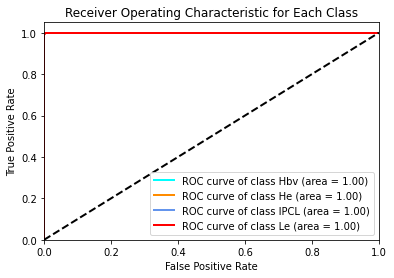

In [38]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []
y_pred_prob_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)
    y_pred_prob_all.extend(y_pred_prob)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_pred_prob_all = np.array(y_pred_prob_all)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Binarize the output
from sklearn.preprocessing import label_binarize
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true_all, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()


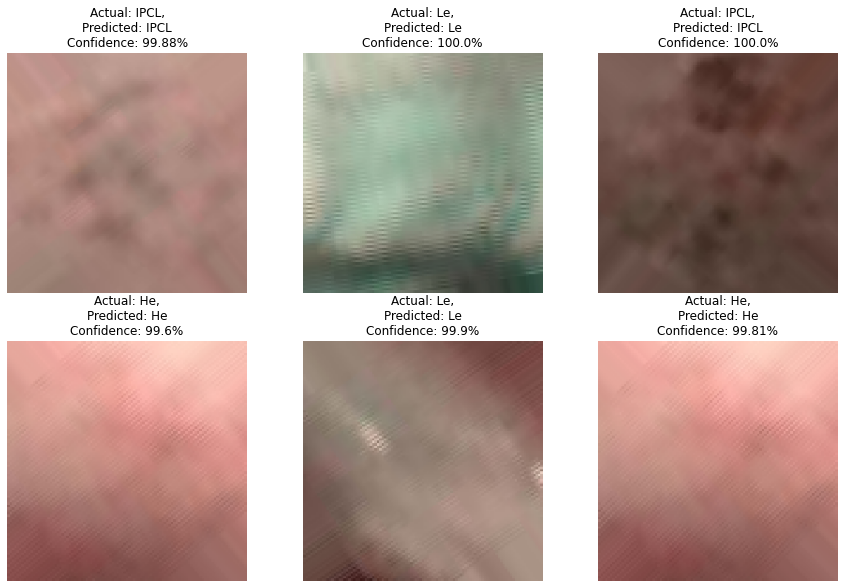

In [39]:
class_names = list(test_generator.class_indices.keys())

# Define the predict function
def predict(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add an extra dimension to the array to match the model's expected input shape
    img_array = tf.expand_dims(img_array, 0)

    # Use the model to make predictions on the image
    predictions = model.predict(img_array)

    # Find the index of the class with the highest probability
    predicted_class = class_names[np.argmax(predictions[0])]

    # Get the confidence level of the prediction (probability of the predicted class)
    confidence = round(100 * np.max(predictions[0]), 2)

    # Return the predicted class and confidence level
    return predicted_class, confidence

# Select random images and plot them
plt.figure(figsize=(15, 15))
random_indices = np.random.choice(len(test_generator), 6, replace=False)

for i, idx in enumerate(random_indices):
    # Get the next batch of data
    x_val, y_val = test_generator[idx]
    
    # Select a random image from the batch
    random_image_index = np.random.randint(x_val.shape[0])
    img = x_val[random_image_index]
    actual_class = class_names[np.argmax(y_val[random_image_index])]

    # Predict the class and confidence
    predicted_class, confidence = predict(model, img)

    # Plot the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Actual: {actual_class},\nPredicted: {predicted_class}\nConfidence: {confidence}%')
    plt.axis('off')

plt.show()

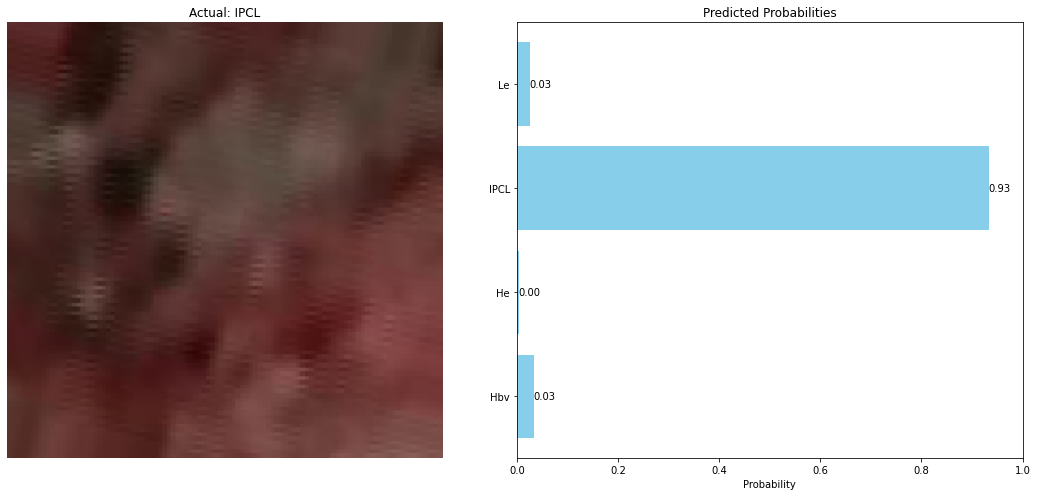

In [40]:
def predict_probabilities(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add an extra dimension to the array to match the model's expected input shape
    img_array = tf.expand_dims(img_array, 0)

    # Use the model to make predictions on the image
    predictions = model.predict(img_array)

    # Get the probability scores for each class
    probabilities = predictions[0]

    return probabilities

# Select one image from the test generator
x_val, y_val = next(validation_generator)
img = x_val[0]
actual_class = class_names[np.argmax(y_val[0])]

# Predict the probabilities for the image
probabilities = predict_probabilities(model, img)

# Plot the image and the probabilities
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Actual: {actual_class}')
plt.axis('off')

plt.subplot(1, 2, 2)
bars = plt.barh(class_names, probabilities, color='skyblue')
plt.xlim([0, 1])
plt.xlabel('Probability')
plt.title('Predicted Probabilities')

# Annotate the barwbys with the probability scores
for bar, prob in zip(bars, probabilities):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
             f'{prob:.2f}', va='center', ha='center')

plt.tight_layout()
plt.show()

In [56]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing import image

# # Define the preprocessing steps
# image_height = 224  # Set the appropriate image height
# image_width = 224   # Set the appropriate image width

# # Function to load and preprocess the image
# def load_and_preprocess_image(img_path):
#     img = image.load_img(img_path, target_size=(image_height, image_width))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array = img_array / 255.0  # Rescale image
#     return img, img_array

# # Function to predict probabilities for all classes
# def predict_probabilities(model, img_array):
#     predictions = model.predict(img_array)
#     probabilities = predictions[0]
#     return probabilities

# # Manually select an image path
# # img_path = "C:\\Users\\Victus\\Desktop\\lbox_2746.jpg"  # Replace with the actual image path

# # Load and preprocess the image
# img, img_array = load_and_preprocess_image(img_path)

# # Predict the probabilities for the image
# probabilities = predict_probabilities(model, img_array)

# # Get class labels
# class_labels = list(test_generator.class_indices.keys())

# # Plot the image and the probabilities
# plt.figure(figsize=(15, 7))
# plt.subplot(1, 2, 1)
# plt.imshow(img)
# plt.title('Selected Image')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# bars = plt.barh(class_labels, probabilities, color='skyblue')
# plt.xlim([0, 1])
# plt.xlabel('Probability')
# plt.title('Predicted Probabilities')

# # Annotate the bars with the probability scores
# for bar, prob in zip(bars, probabilities):
#     plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
#              f'{prob:.2f}', va='center', ha='center')

# plt.tight_layout()
# plt.show()


NameError: name 'img_path' is not defined

In [41]:
def calculate_flops(model, table=False):
    if table:
        print('%25s | %16s | %16s | %16s | %16s | %6s | %6s' % (
            'Layer Name', 'Input Shape', 'Output Shape', 'Kernel Size', 'Filters', 'Strides', 'FLOPS'))
        print('-' * 170)

    t_flops = 0
    t_macc = 0

    for l in model.layers:
        o_shape, i_shape, strides, ks, filters = ['', '', ''], ['', '', ''], [1, 1], [0, 0], [0, 0]
        flops = 0
        macc = 0
        name = l.name

        factor = 1000000

        if 'InputLayer' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = i_shape

        if 'Reshape' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

        if 'Add' in str(l) or 'Maximum' in str(l) or 'Concatenate' in str(l):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = (len(l.input) - 1) * i_shape[0] * i_shape[1] * i_shape[2]

        if 'Average' in str(l) and 'pool' not in str(l):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = len(l.input) * i_shape[0] * i_shape[1] * i_shape[2]

        if 'BatchNormalization' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if 'Activation' in str(l) or 'activation' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if 'pool' in str(l) and 'Global' not in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            strides = l.strides
            ks = l.pool_size
            flops = ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1]) * (ks[0] * ks[1] * i_shape[2]))

        if 'Flatten' in str(l):
            i_shape = l.input.shape[1:4].as_list()
            flops = 1
            out_vec = 1
            for i in range(len(i_shape)):
                flops *= i_shape[i]
                out_vec *= i_shape[i]
            o_shape = flops
            flops = 0

        if 'Dense' in str(l):
            i_shape = l.input.shape[1:4].as_list()[0]
            if i_shape is None:
                i_shape = out_vec
            o_shape = l.output.shape[1:4].as_list()
            flops = 2 * (o_shape[0] * i_shape)
            macc = flops / 2

        if 'Padding' in str(l):
            flops = 0

        if 'Global' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            flops = ((i_shape[0]) * (i_shape[1]) * (i_shape[2]))
            o_shape = [l.output.get_shape()[1:4].as_list(), 1, 1]
            out_vec = o_shape

        if 'Conv2D' in str(l) and 'DepthwiseConv2D' not in str(l) and 'SeparableConv2D' not in str(l):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if filters is None:
                filters = i_shape[2]

            flops = 2 * ((filters * ks[0] * ks[1] * i_shape[2]) * (
                    (i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        if 'Conv2D' in str(l) and 'DepthwiseConv2D' in str(l) and 'SeparableConv2D' not in str(l):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if filters is None:
                filters = i_shape[2]

            flops = 2 * (
                    (ks[0] * ks[1] * i_shape[2]) * ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        t_macc += macc
        t_flops += flops

        if table:
            print('%25s | %16s | %16s | %16s | %16s | %6s | %5.2f' % (
                name, str(i_shape), str(o_shape), str(ks), str(filters), str(strides), flops))

    # Convert to Giga (G) for FLOPs
    t_flops_in_giga = t_flops / 10**9

    # Convert to Mega (M) for MACs
    t_macc_in_mega = t_macc / 10**6

    # Decide on units for MACs
    if t_macc >= 10**9:
        macc_unit = "G"
        macc_value = t_macc / 10**9
    else:
        macc_unit = "M"
        macc_value = t_macc_in_mega

    print(f"Total FLOPs: {t_flops_in_giga:.2f} G")
    print(f"Total MACs: {macc_value:.3f} {macc_unit}")

    return

calculate_flops(model)


Total FLOPs: 11.25 G
Total MACs: 5.612 G
